In [2]:
# 가중치 시각화
import keras
model = keras.models.load_model('best-cnn-model.tf')
model.layers # 케라스 모델의 레이어 확인

2025-08-26 19:48:40.895704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 19:48:40.924620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-26 19:48:40.924670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-26 19:48:40.924700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 19:48:40.930273: I tensorflow/core/platform/cpu_feature_g

In [3]:
# 첫 번째 합성곱 층의 가중치와 절편 확인
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape) # 차례로 가중치와 절편

(3, 3, 1, 32) (32,)


In [4]:
# numpy 배열로 변경 및 평균과 표준편차 계산
conv_weight = conv.weights[0].numpy()
print(conv_weight.mean(), conv_weight.std())

-0.027000753 0.24611643


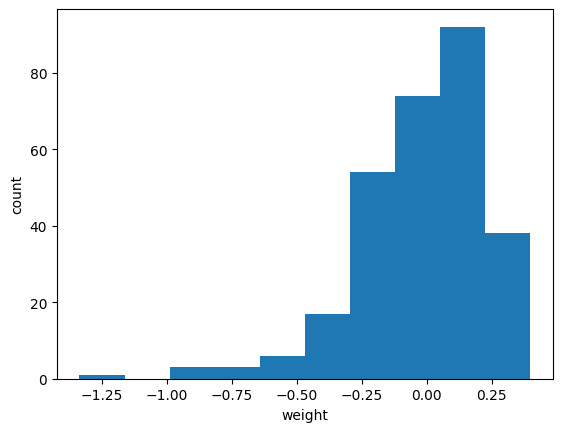

In [5]:
# 가중치의 분포를 히스토그램으로 확인
import matplotlib.pyplot as plt

plt.hist(conv_weight.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

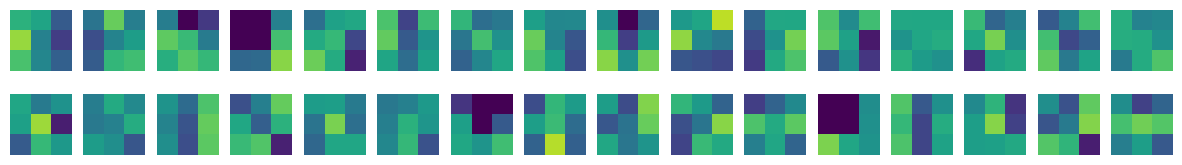

In [6]:
# 32개의 커널을 16개씩 두 줄로 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weight[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

In [7]:
# 그래프를 보면 가중치 값이 무작위로 나열된 것이 아닌 패턴을 볼 수 있다
# ex. 두 번째 줄의 왼쪽에서 여덟 번째 가중치는 왼쪽 3픽셀의 값이 다른 픽셀보다 상대적으로 낮으므로, 이 가중치는 오른쪽에 놓인 직선을 만나면 크게 활성화 됨

In [8]:
# 훈련하지 않은 합성곱 신경망을 만들어 비교
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Input(shape=(28,28,1)))
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))

# 첫 번째 층의 가중치를 no_training_conv 변수에 저장
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [9]:
# 평균과 표준편차 확인
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0020478102 0.08354931


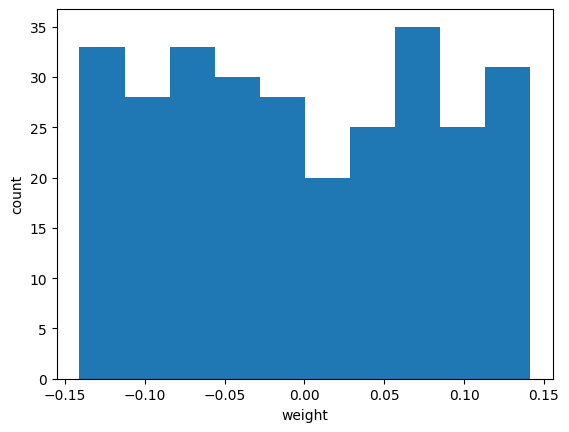

In [10]:
# 가중치 배열 히스토그램으로 확인
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

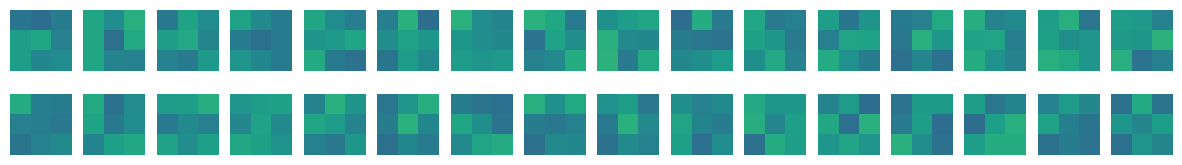

In [11]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

In [12]:
# 합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 패턴을 학습했다는 사실을 알 수 있음

In [13]:
# 함수형 API의 구현
inputs = keras.Input(shape=(784,))
dense1 = keras.layers.Dense(100, activation='relu')
dense2 = keras.layers.Dense(10, activation='softmax')

hidden = dense1(inputs)
outputs = dense2(hidden)
func_model = keras.Model(inputs, outputs)

In [14]:
# 함수형 API 필요성? -> 여러입력, 여러출력, 레이어 연결이 일자형이 아닌 복잡한 그래프 구조일때, 레이어를 재사용하거나 병렬branch 만들때 필요
# ex. 하나의 입력을 두 갈래로 흘려보내서 다시 합치기 가능
# 실제 필요한 상황 -> 이미지+텍스트 동시에 입력, 동시에 카테고리 분류+좌표 회귀, 레이어 끼리 다양한 연결을 해야 할 때

In [15]:
# model 객체의 입력 확인하기
print(model.inputs)

[<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_1')>]


In [16]:
conv_acti = keras.Model(model.inputs[0], model.layers[0].output)
# conv_acti의 predict() 메서드를 호출하면 첫 번째 Conv2D의 출력을 반환

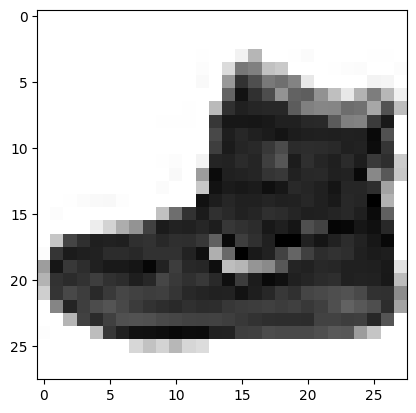

In [17]:
# 특성맵 시각화
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [18]:
# 이미지 전처리(첫 번째 차원 -> 배치차원) 및 feacher map 크기 확인
ankle_boot = train_input[0:1].reshape(-1,28,28,1) / 255.0
feature_maps = conv_acti.predict(ankle_boot)

print(feature_maps.shape)

1/1 [==============================] - 0s 225ms/step
(1, 28, 28, 32)


2025-08-26 19:48:44.232322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904


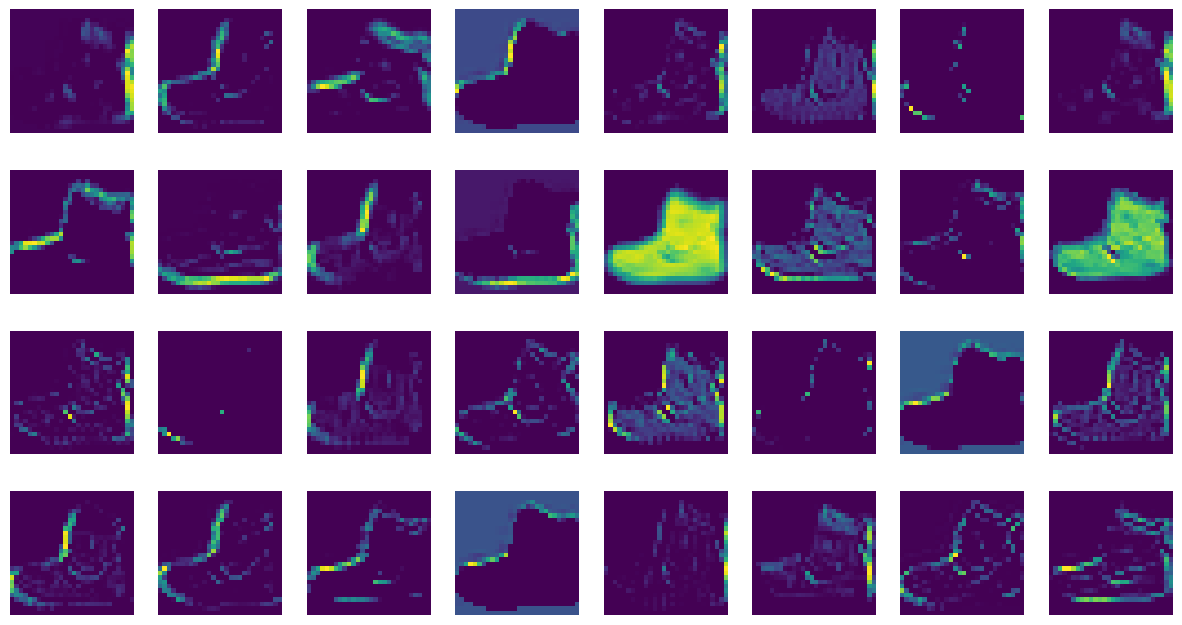

In [ ]:
# feature map 시각화
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:,i*8+j]) # (batch_size, height, width, channels)
        axs[i,j].axis('off')
plt.show()

In [20]:
# 두 번째 합성곱 층 확인
conv2_acti = keras.Model(model.inputs[0], model.layers[2].output)
feature_maps = conv2_acti.predict(ankle_boot)

# feature map 크기확인
print(feature_maps.shape)

1/1 [==============================] - 0s 110ms/step
(1, 14, 14, 64)


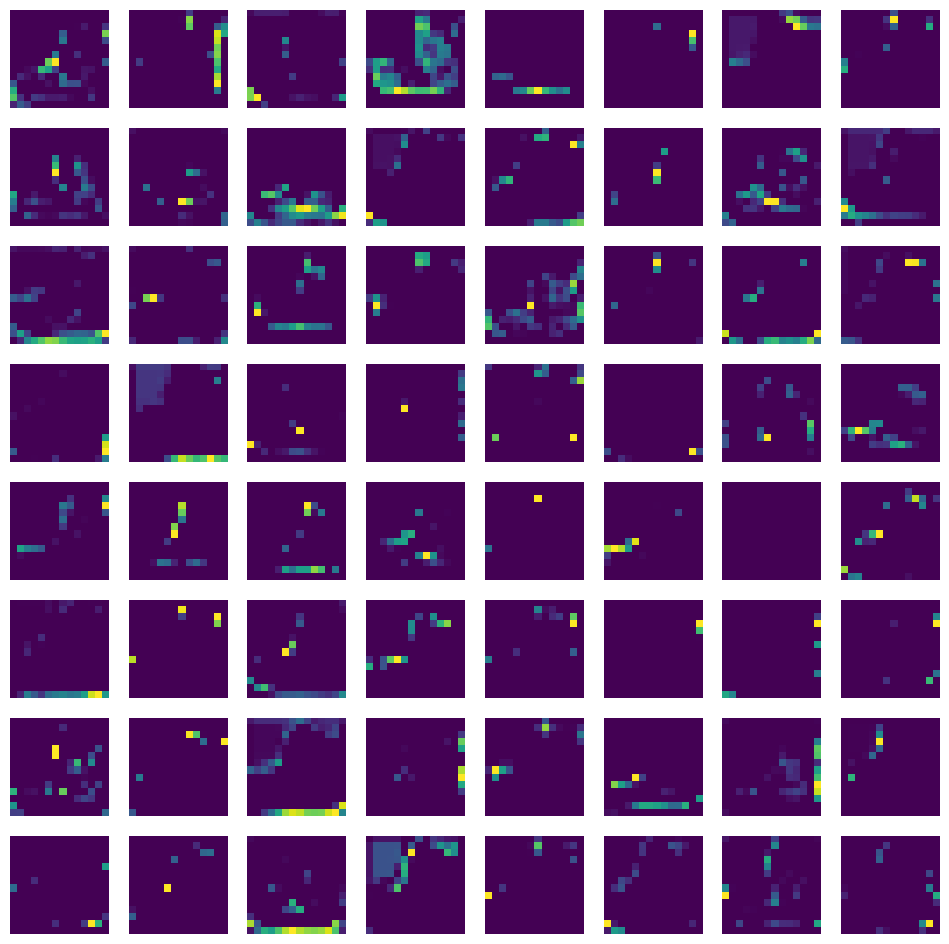

In [ ]:
# feature map 시각화
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:,i*8+j]) # (batch_size, height, width, channels)
        axs[i,j].axis('off')
plt.show()